# Tabular regression with Amazon SageMaker AutoGluon-Tabular algorithm
[github](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/autogluon_tabular/Amazon_Tabular_Regression_AutoGluon.ipynb)

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/introduction_to_amazon_algorithms|autogluon_tabular|Amazon_Tabular_Regression_AutoGluon.ipynb)

---

---
This notebook demonstrates the use of Amazon SageMaker [AutoGluon-Tabular](https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html) algorithm to train and host a tabular regression model. Tabular regression is the task of analyzing the relationship between predictor variables and a response variable in a structured or relational data.

In this notebook, we demonstrate two use cases of tabular regression models:

* How to train a tabular model on an example dataset to do regression.
* How to use the trained tabular model to perform inference, i.e., predicting new samples.

Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Train A Tabular Model on Abalone Dataset](#2.-Train-a-Tabular-Model-on-Abalone-Dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training Parameters](#2.2.-Set-Training-Parameters)
    * [Start Training](#2.3.-Start-Training)
3. [Deploy and Run Inference on the Trained Tabular Model](#3.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
4. [Evaluate the Prediction Results Returned from the Endpoint](#4.-Evaluate-the-Prediction-Results-Returned-from-the-Endpoint)

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.

---

In [ ]:
# !pip install sagemaker ipywidgets --upgrade --quiet


---
To train and host on Amazon SageMaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3.

---

### Config

In [1]:
from omegaconf import OmegaConf

In [2]:
path_root = "/Users/elnath/004_deep_learning/SageMaker-Practical-Course"
conf = OmegaConf.load(f"{path_root}/config_my.json")

In [3]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

# aws_role = get_execution_role()
aws_role = conf.common.execution_role
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/elnath/Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/elnath/Library/Application Support/sagemaker/config.yaml


## 2. Train a Tabular Model on Abalone Dataset

---

In this demonstration, we will train a tabular algorithm on the [Abalone](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) dataset. The dataset contains examples of eight physical measurements such as length, diameter, and height to predict the age of abalone. Among the eight physical measurements (features), there are one categorical feature and seven numerical features. Abalone dataset is downloaded from [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html).

Below is the table of the first 5 examples in the Abalone dataset.

| Target | Feature_0 | Feature_1 | Feature_2 | Feature_3 | Feature_4 | Feature_5 | Feature_6 | Feature_7 |
|:------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|
|   11   |     1     |   0.585   |   0.455   |   0.150   |  0.9870   |  0.4355   |  0.2075   |  0.3100   |
|   5    |     3     |   0.325   |   0.245   |   0.075   |  0.1495   |  0.0605   |  0.0330   |  0.0450   |
|   9    |     3     |   0.580   |   0.420   |   0.140   |  0.7010   |  0.3285   |  0.1020   |  0.2255   |
|   12   |     2     |   0.480   |   0.380   |   0.145   |  0.5900   |  0.2320   |  0.1410   |  0.2300   |
|   11   |     2     |   0.440   |   0.355   |   0.115   |  0.4150   |  0.1585   |  0.0925   |  0.1310   |

If you want to bring your own dataset, below are the instructions on how the training data should be formatted as input to the model.

A S3 path should contain two sub-directories 'train/', and 'validation/' (optional). Each sub-directory contains a 'data.csv' file (The Abalone dataset used in this example has been prepared and saved in `training_dataset_s3_path` shown below).

* The 'data.csv' files under sub-directory 'train/' and 'validation/' are for training and validation, respectively. The validation data is used to compute a validation score at the end of each training iteration or epoch. An early stopping is applied when the validation score stops improving. If the validation data is not provided, a fraction of training data is randomly sampled to serve as the validation data. The fraction value is selected based on the number of rows in the training data. Default values range from 0.2 at 2,500 rows to 0.01 at 250,000 rows. For details, see [AutoGluon-Tabular Documentation](https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit).
* The first column of the 'data.csv' should have the corresponding target variable. The rest of other columns should have the corresponding predictor variables (features).
* All the categorical and numeric features, and target can be kept as their original formats.


Citations:

- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science


### 2.1. Retrieve Training Artifacts

___

Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

For the training algorithm, we have one choice in this demonstration.
* [AutoGluon-Tabular](https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html): To use this algorithm, specify `train_model_id` as `autogluon-regression-ensemble` in the cell below.

Note. [LightGBM](https://lightgbm.readthedocs.io/en/latest/) (`train_model_id: lightgbm-regression-model`), [CatBoost](https://catboost.ai/en/docs/) (`train_model_id:catboost-regression-model`), [XGBoost](https://xgboost.readthedocs.io/en/latest/) (`train_model_id: xgboost-regression-model`), [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (`train_model_id: sklearn-regression-linear`), and [TabTransformer](https://arxiv.org/abs/2012.06678) (`train_model_id: pytorch-tabtransformerregression-ensemble`) are the other choices in the tabular regression category. Since they have different input-format requirements, please check separate notebooks `lightgbm_catboost_tabular/Amazon_Tabular_Regression_LightGBM_CatBoost.ipynb`, `xgboost_linear_learner_tabular/Amazon_Tabular_Regression_XGBoost_LinearLearner.ipynb`, and `tabtransformer_tabular/Amazon_Tabular_Regression_TabTransformer.ipynb` for details.

---

In [4]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "autogluon-regression-ensemble", "*", "training"

# training_instance_type = "local"
training_instance_type = "ml.p3.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune. In tabular case, however, the pre-trained model tarball is dummy and fine-tune means training from scratch.
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Using model 'autogluon-regression-ensemble' with wildcard version identifier '*'. You can pin to version '2.0.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


### 2.2. Set Training Parameters

---
Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [5]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/tabular_regress/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

# sagemaker-ap-northeast-2-688554574862
output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-tabular-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [6]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for training the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["auto_stack"] = "True"
print(hyperparameters)

{'eval_metric': 'auto', 'presets': 'medium_quality', 'auto_stack': 'True', 'num_bag_folds': '0', 'num_bag_sets': '1', 'num_stack_levels': '0', 'refit_full': 'False', 'set_best_to_refit_full': 'False', 'save_space': 'False', 'verbosity': '2'}


### 2.3. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job.
Note. We do not use hyperparameter tuning for AutoGluon models because [AutoGluon](https://arxiv.org/abs/2003.06505) succeeds by ensembling multiple models and stacking them in multiple layers rather than focusing on model/hyperparameter selection.

---

In [7]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator.fit({"training": training_dataset_s3_path}, logs=True, job_name=training_job_name)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/elnath/Library/Application Support/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: jumpstart-example-autogluon-regression--2024-03-25-09-14-35-645


2024-03-25 09:14:36 Starting - Starting the training job
2024-03-25 09:14:36 Pending - Training job waiting for capacity......
2024-03-25 09:15:16 Pending - Preparing the instances for training...
2024-03-25 09:16:07 Downloading - Downloading input data...
2024-03-25 09:16:27 Downloading - Downloading the training image..................
2024-03-25 09:19:23 Training - Training image download completed. Training in progress...2024-03-25 09:19:47,086 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2024-03-25 09:19:47,116 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"auto_stack":"True","eval_metric":"auto","num_bag_folds":"0","num_bag_sets":"1","num_stack_levels":"0","presets":"medium_quality","refit_full":"False","save_space":"False","set_best_to_refit_full":"False","verbosity":"2"}', 'SM_USER_ENTRY_POINT': 'transfer_learning.py', 'SM_FRAMEWORK_

## 3. Deploy and Run Inference on the Trained Tabular Model

---

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output a numerical value to estimate the corresponding target value.

We start by retrieving the artifacts and deploy the `tabular_estimator` that we trained.

---

In [8]:
inference_instance_type = "ml.m5.2xlarge"
# inference_instance_type = "local"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-ap-northeast-2-688554574862/jumpstart-example-tabular-training/output/jumpstart-example-autogluon-regression--2024-03-25-09-14-35-645/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-ap-northeast-2/source-directory-tarballs/autogluon/inference/regression/v1.0.0/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-ap-northeast-2-688554574862/sagemaker-jumpstart-2024-03-25-09-20-51-473/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2024-03-25-09-20-51-473
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-autogluon-regression--2024-03-25-09-20-51-473
INFO:sagemaker:Creating endpoint with name jumpstart-example-autogluon-regression--2024-03-25-09-20-51-473


------!

---
Next, we download a hold-out ABALONE test data from the S3 bucket for inference.

---

In [9]:
jumpstart_assets_bucket = f"jumpstart-cache-prod-{aws_region}"
test_data_prefix = "training-datasets/tabular_regress/test"
test_data_file_name = "data.csv"

boto3.client("s3").download_file(
    jumpstart_assets_bucket, f"{test_data_prefix}/{test_data_file_name}", test_data_file_name
)

---
Next, we read the Abalone test data into pandas data frame, prepare the ground truth target and predicting features to send into the endpoint.

Below is the screenshot of the first 5 examples in the Abalone test set. All of the test examples with features
from ```Feature_1``` to ```Feature_8``` are sent into the deployed model to get model predictions, to estimate the ground truth ```Target``` column.

---

In [10]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# read the data
test_data = pd.read_csv(test_data_file_name, header=None)
test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(
    f"{bold}The first 5 observations of the test data: {unbold}"
)  # Feature_1 is the categorical variables and rest of other features are numeric variables.
test_data.head(5)

The test dataset contains 626 examples and 9 columns.

The first 5 observations of the test data: 


,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8
0,11,1,0.585,0.455,0.150,0.9870,0.4355,0.2075,0.3100
1,5,3,0.325,0.245,0.075,0.1495,0.0605,0.0330,0.0450
2,9,3,0.580,0.420,0.140,0.7010,0.3285,0.1020,0.2255
3,12,2,0.480,0.380,0.145,0.5900,0.2320,0.1410,0.2300
4,11,2,0.440,0.355,0.115,0.4150,0.1585,0.0925,0.1310


---
The following code queries the endpoint you have created to get the prediction for each test example. 
The `query_endpoint()` function returns a array-like of shape (num_examples, ).

---

In [11]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_resonse(query_response):
    predictions = json.loads(query_response["Body"].read())
    return np.array(predictions["prediction"])


query_response = query_endpoint(features.to_csv(header=False, index=False).encode("utf-8"))
model_predictions = parse_resonse(query_response)

## 4. Evaluate the Prediction Results Returned from the Endpoint

---
We evaluate the predictions results returned from the endpoint by following two ways.

* Visualize the prediction results by a residual plot to compare the model predictions and ground truth targets.

* Measure the prediction results quantitatively.

---

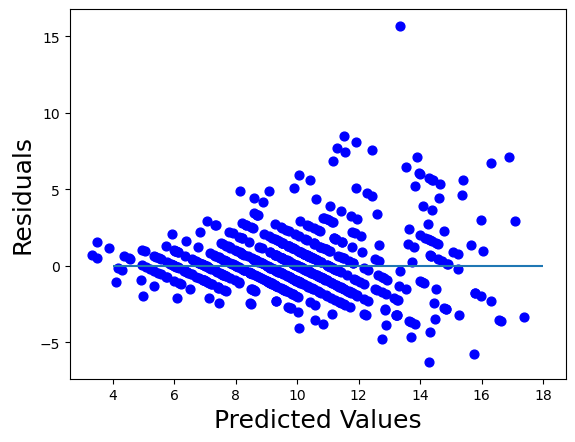

In [12]:
# Visualization: a residual plot to compare the model predictions and ground truth targets. For each example, the residual value
# is the subtraction between the prediction and ground truth target.
# We can see that the points in the residual plot are randomly dispersed around the horizontal axis y = 0,
# which indicates the fitted regression model is appropriate for the ABALONE data

residuals = ground_truth_label.values[:, 0] - model_predictions
plt.scatter(model_predictions, residuals, color="blue", s=40)
plt.hlines(y=0, xmin=4, xmax=18)
plt.xlabel("Predicted Values", fontsize=18)
plt.ylabel("Residuals", fontsize=18)
plt.show()

In [13]:
# Evaluate the model predictions quantitatively.
eval_r2_score = r2_score(ground_truth_label.values, model_predictions)
eval_mse_score = mean_squared_error(ground_truth_label.values, model_predictions)
eval_mae_score = mean_absolute_error(ground_truth_label.values, model_predictions)
print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{r2_score.__name__}{unbold}: {eval_r2_score}{newline}"
    f"{bold}{mean_squared_error.__name__}{unbold}: {eval_mse_score}{newline}"
    f"{bold}{mean_absolute_error.__name__}{unbold}: {eval_mae_score}{newline}"
)

Evaluation result on test data:
r2_score: 0.6108650775322776
mean_squared_error: 4.4532511712817255
mean_absolute_error: 1.4510031641481784


---
Next, we delete the endpoint corresponding to the trained model.

---

In [14]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2024-03-25-09-20-51-473
INFO:sagemaker:Deleting endpoint configuration with name: jumpstart-example-autogluon-regression--2024-03-25-09-20-51-473
INFO:sagemaker:Deleting endpoint with name: jumpstart-example-autogluon-regression--2024-03-25-09-20-51-473
